# Showcase of the DQN agent
This notebook will showcase the code for the DQN agent found in "pendulumCrane/agent/dqn_agent.py"

First the necessary imports

In [48]:
import matplotlib.pyplot as plt
import argparse
import sys

import gym
import pendulumCrane

from gym import wrappers, logger

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

from collections import deque
import random

from collections import namedtuple
import numpy as np

import math

## Experience replay
We use a replay buffer to store transitions and sample from this buffer when training the network.

In [49]:
## Replay buffer
class ReplayMemory(object):
    """Experience Replay Memory"""
    
    def __init__(self, capacity):
        #self.size = size
        self.memory = deque(maxlen=capacity)
    
    def add(self, *args):
        """Add experience to memory."""
        self.memory.append([*args])
    
    def sample(self, batch_size):
        """Sample batch of experiences from memory with replacement."""
        return random.sample(self.memory, batch_size)
    
    def count(self):
        return len(self.memory)

## The Neural Network
The network is a standard feed forward neural net, with 3 hidden layers and 128 hidden units in each, with dropout between each layer.

In [50]:
# DQN class
class DQN(nn.Module):

    def __init__(self, n_inputs, n_outputs, learning_rate):
        super(DQN, self).__init__()
        self.hidden_size = 128

        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(n_inputs,self.hidden_size)
        self.fc2 = nn.Linear(self.hidden_size, self.hidden_size)
        self.fc3 = nn.Linear(self.hidden_size, self.hidden_size)
        self.fc4 = nn.Linear(self.hidden_size, self.hidden_size)
        self.fc5 = nn.Linear(self.hidden_size, self.hidden_size)

        self.out = nn.Linear(self.hidden_size, n_outputs)

        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate, weight_decay=1e-6)

        # define dropout
        self.dropout = torch.nn.Dropout(p=0.5, inplace=False)

    def forward(self, x):
        # Standard FNN layers

        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc3(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.out(x)

        return F.softmax(x, dim=0)

## Helper functions and reward calculation
To use a continuous environment, we pass the neuron index of the selected action through a small pseudo DAC, which converts it to a voltage in the D2C function.

We also calculate the reward used internally in the agent, as the environment was shared between DQN and DPPG, which uses different reward structures.

In [51]:
# Convert the index of the output neuron, to a continuous value for the environment
def D2C(discrete_action):
    pos_voltage = 2.0 # Go left
    neg_voltage = -2.0 # Go right
    volt_range = np.array([-9.0, -7.0, -5.0, -2.0, -1.0, -0.1, 0.0, 0.1, 1.0, 2.0, 5.0, 7.0, 9.0])
    output = volt_range[int(discrete_action)]

    return output


def agent_reward(action, next_state, reward_array, old_state):

    # Calculate distance 
    x_goal = next_state[2]
    x_pos = next_state[0]
    distance = x_pos - x_goal

    x_goal_old = old_state[2]
    x_pos_old = old_state[0]
    old_distance = x_pos_old - x_goal_old

    # Calculate end effector position of pendulum
    theta = next_state[1]

    pen_length = 0.7 # Length of pendulum - Placeholder
    theta_pos = x_pos + math.sin(theta)*pen_length

    # Use distance of end effector instead of sledge
    distance_pendulum = theta_pos - x_goal

    dist_dif = distance**2 - old_distance**2

    reward = 0
    reward_type = 0
    # Base reward:
    if dist_dif > 0:
        reward = -1
        reward_type = 1
    elif dist_dif == 0:
        reward = 1
        reward_type = 0
    elif dist_dif < 0:
        reward = 1
        reward_type = 2


    reward_array[reward_type] += 1 


    # Distance bonus
    dist_bonus = 2 - abs(distance)*10
    reward = reward + dist_bonus

    # Theta_pos penalty
    theta_p = next_state[1]
    theta_p = (x_pos+math.sin(theta_p)*0.7)-x_pos
    theta_penalty = abs(theta_p)*2

    reward = reward - theta_penalty
    return reward, reward_array

def random_action(n_outputs):
    action = np.random.randint(n_outputs,size=1)
    action = float(action)
    return action



def select_action(state, step_count):
    # Determine if we are taking a random action or not
    Eps_start = 0.9
    Eps_end = 0.15
    Eps_decay = 25

    sample = random.random()
    Eps_threshold = Eps_end + (Eps_start - Eps_end) * math.exp(-1. *step_count/Eps_decay)
    #step_count += 1

    action_type = "R" # Random action

    if sample > Eps_threshold: 
        action_type = "Q" # Q action

    return action_type

## Optimizer
The optimizer samples random transitions from the replay buffer and uses them as a basis for training the network, based on the Huber Loss.

In [52]:
def simple_optimizer(n_inputs):
    if replay_memory.count() < batch_size:
        return

    global num_param_updates
    # sample batch from replay memory
    batch = np.array(replay_memory.sample(batch_size))#,dtype=float)


    # Extract from batch
    ss, aa, rr, ss1, dd = np.stack(batch[:,0]), np.stack(batch[:,1]), np.stack(batch[:,2]), np.stack(batch[:,3]), np.stack(batch[:,4]).astype(int)

    # Convert to Tensors
    ss = torch.from_numpy(ss).float().view(-1,n_inputs)
    aa = torch.from_numpy(aa).long().view(-1,1)
    rr = torch.from_numpy(rr).float().view(-1,1)
    ss1 = torch.from_numpy(ss1).float().view(-1,n_inputs)
    dd = torch.from_numpy(dd).float().view(-1,1)



    # Forward pass on batch
    policy_net.optimizer.zero_grad()
    Q = policy_net(ss.float())

    with torch.no_grad():
        # Get the q value for all possible moves
        Q1 = policy_net(ss1.float())

    yk = Q1.clone()
    for k in range(batch_size):
        yk_k = rr[k] + gamma * Q1[k].max().item() * (not dd[k])
        yk[k, aa[k]] = yk_k

    ## update network weights

    # Compute Huber loss
    loss = F.smooth_l1_loss(Q, yk)

    # Old loss function
    #loss = policy_net.loss(Q, yk)

    loss.backward()
    policy_net.optimizer.step()

    num_param_updates += 1

    if num_param_updates % target_update_freq == 0:
        # update target network parameters from policy network parameters
        target_net.load_state_dict(policy_net.state_dict())

## Primary training loop
Specify the OpenAI Gym environment, and define hyper parameters.
Select if the system should load a previously saved network, if the new network should be saved after training, and if the system should train or not.

In [53]:
 ####### MAIN #######

# Import environment
env = gym.make('CartPoleCrane-v3')

# Number of inputs and outputs	
n_inputs = 3 
n_outputs = 13 
print("Number of inputs: ", n_inputs, ", number of outputs: ", n_outputs)

##### train Deep Q-network #####

# Parameters
num_episodes = 20 # default: 50 # Number of episodes
episode_limit = 800 # Length of episode

batch_size = 32 # Default: 32
learning_rate = 0.002 # Default = 0.002
gamma = 0.99 # discount rate
replay_memory_capacity = 5000
prefill_memory = False
val_freq = 10 # validation frequency


num_param_updates = 0
target_update_freq = 25 # Default 25

# if gpu is to be used
device = torch.device("cpu")
dtype = torch.FloatTensor
dlongtype = torch.LongTensor

# initialize DQN
policy_net = DQN(n_inputs, n_outputs, learning_rate).to(device)
target_net = DQN(n_inputs, n_outputs, learning_rate).to(device)
target_net.load_state_dict(policy_net.state_dict())


## Load network 
load = 0
save = 0
train = 1
if load:
	print("Loading network")
	policy_net.load_state_dict(torch.load('pendulumCrane/pretrainedNets/dqn_net.pt'))
	target_net.load_state_dict(torch.load('pendulumCrane/pretrainedNets/dqn_net.pt'))

if not train:
	print("Skipping Training")
	data_array = np.array([0,0,0,0,0,0])
	num_episodes = 0

# Initialize replay memory
replay_memory = ReplayMemory(replay_memory_capacity)

#eps_check(num_episodes)

val_ep = False


# Tau from environment
tau_agent = env.env.tau
print("Tau: ", tau_agent, " Number of steps: ", episode_limit, " Episode duration: ", tau_agent*episode_limit, " [s]")

# Collect a set of fixed states for average Q metric
state = env.reset()

s_fix_1 = state # x, theta, goal
s_fix_1[0] = 0.05
s_fix_1[2] = 0.95

state = env.reset()
s_fix_2 = state
s_fix_2[0] = 0.95
s_fix_2[2] = 0.05

state = env.reset()
s_fix_3 = state
s_fix_3[0] = 0.25
s_fix_3[2] = 0.75

state = env.reset()
s_fix_4 = state
s_fix_4[0] = 0.75
s_fix_4[2] = 0.25

fixed_states = np.array([s_fix_1, s_fix_2, s_fix_3, s_fix_4])
print("Fixed states: ", fixed_states)

Q_average = []

output_histogram = np.zeros(n_outputs)
reward_array = np.zeros(4)


## Training loop
print("Start training")
rewards, lengths = [], []
final_distances = []
initial_distances = []
state = env.reset()

## Data
#data_array = np.array([0,0,0,0])
#print("Size of array :", data_array.size)


epsilon = 1.0

step_count = 0
max_theta = 0
for i in range(num_episodes):

	# Reset environment and values
	# Get initial observation 
	state = env.reset()
	ep_reward = 0
	final_distance = 0

	# Initialize Action array storage
	action_array = np.array([[0,0,0,0]])

	# Initial distance
	x_goal = state[2]
	x_pos = state[0]
	initial_distance = x_pos - x_goal
	distance = initial_distance

	for j in range(episode_limit):

		# Select action based on states, the epsilon greedy strategy and validation episode flag
		action_type = select_action(state, step_count)

		#if np.random.rand() >= epsilon:
		if action_type == "Q":
			with torch.no_grad():
				# Get the q value for all possible moves
				q_value_all_actions = policy_net(torch.from_numpy(state).float())
				# Select the action that has the highest value
				action = q_value_all_actions.argmax().item()

				# Update output histogram
				output_histogram[int(action)] += 1

		else:
			action = random_action(n_outputs)

		# Perform action and get results
		numpy_action = D2C(action) # Discrete action as a numpy variable
		next_state, reward_old, done, _ = env.step(numpy_action)

		# Old distance
		old_distance = distance

		# New distance 
		x_goal = next_state[2]
		x_pos = next_state[0]
		distance = x_pos - x_goal


		# get reward
		reward, reward_array = agent_reward(numpy_action, next_state, reward_array, state)

		# Check if done
		if done:
			lengths.append(j + 1)
			break

		replay_memory.add(state, action, reward, next_state, done)

		# Perform model optimization (It automatically checks if replay buffer is full)
		if (j+1) % 2 == 0:
			simple_optimizer(n_inputs)


		# bookkeeping
		state = next_state
		ep_reward += reward

	### End of episode
	
	final_distances.append(distance)
	rewards.append(ep_reward)
	lengths.append(j+1)
	initial_distances.append(initial_distance)



	step_count += 1
	# Validation episode
	if (i+1) % val_freq == 0:
		validation_rewards = []
		#q_diff = []
		for ii in range(4):
			data_array = np.array([0,0,0,0,0,0])
			s = env.reset()

			# Fixed state for validation
			s[0] = 0.05 # Start pos
			s[2] = 0.80 # Goal pos
			env.env.state[2] = s[0]
			env.env.set_goal(s[2])

			reward_val = 0
			for jj in range(episode_limit):
				with torch.no_grad():
					# Get the q value for all possible moves
					Q_probs = policy_net(torch.from_numpy(s).float())
					# Select the action that has the highest value
					action = Q_probs.argmax().item()

				a_env = D2C(action)
				s_new, r_old, done, _ = env.step(a_env)

				old_distance = distance
				# Update distance
				x_goal = s[2]
				x_pos = s[0]
				distance = x_pos - x_goal

				# Calculate actual reward
				r, reward_array = agent_reward(a_env, s_new, reward_array, s)
				#q_diff = qd

				time_stamp = tau_agent*jj
				## Data 
				reward_val += r
				s = s_new
				if done: 
					break
			#print("Breaking, ii: ", ii, " jj: ", jj)
			validation_rewards.append(reward_val)
		print('{:4d}. mean training reward: {:6.2f}, mean validation reward: {:6.2f}'.format(i+1, np.mean(rewards[-val_freq:]), np.mean(validation_rewards)))

		# Average Q value on fixed states
		Q_ep = []
		for ii in range(4):

			with torch.no_grad():
				# Get the q value for all possible moves
				Q_probs = policy_net(torch.from_numpy(fixed_states[ii]).float())
			# get the highest value action
			max_action = Q_probs.max().item()
			Q_ep.append(max_action)
		Q_average.append(np.mean(Q_ep))



print("Training completed")

/home/casper/Dropbox/DL/gym/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


StateSpaceDiscrete(
array([[-1.89855434e-03, -5.31327561e-03,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 1.20559430e-01,  3.37396440e-01,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 6.16210292e-06,  1.74810578e-05,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [-2.18335220e-04,  1.20991136e-03,  0.00000000e+00,
         9.94166023e-01, -2.50653640e-01],
       [-7.87649478e-06,  1.41947131e-05,  0.00000000e+00,
         1.99499836e-02,  9.97491020e-01]]),
array([[ 4.41690012e-01],
       [ 1.96066911e+01],
       [ 3.26992751e-04],
       [-3.58022490e-02],
       [-4.18525342e-04]]),
array([[ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        , 57.29577951]]),
array([[0],
       [0]]),
dt: 0.02
)
Number of inputs:  3 , number of outputs:  13
Tau:  0.02  Number of steps:  800  Episode duration:  16.0  [s]
Fixed states:  [[0.05 0.   0.95]
 [0.95

## After training
Functions to save the network, plot general data and display a simulation of the resulting network.

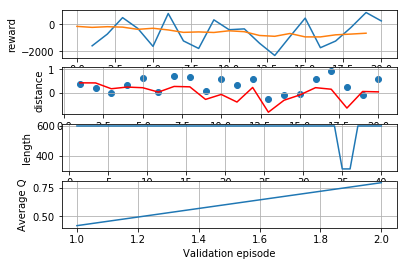

StateSpaceDiscrete(
array([[-1.89855434e-03, -5.31327561e-03,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 1.20559430e-01,  3.37396440e-01,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 6.16210292e-06,  1.74810578e-05,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [-2.18335220e-04,  1.20991136e-03,  0.00000000e+00,
         9.94166023e-01, -2.50653640e-01],
       [-7.87649478e-06,  1.41947131e-05,  0.00000000e+00,
         1.99499836e-02,  9.97491020e-01]]),
array([[ 4.41690012e-01],
       [ 1.96066911e+01],
       [ 3.26992751e-04],
       [-3.58022490e-02],
       [-4.18525342e-04]]),
array([[ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        , 57.29577951]]),
array([[0],
       [0]]),
dt: 0.02
)


In [54]:
## Saving network
if save:
    print("Saving network")
    torch.save(policy_net.state_dict(), './policy_net.pt')

## Plot
def moving_average(a, n=10) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret / n


if train:
    fig, ax = plt.subplots(4,1)
    ax[0].plot(range(1, len(rewards)+1), rewards, label='training reward')
    ax[0].plot(moving_average(rewards))
    ax[0].set_xlabel('episode')
    ax[0].set_ylabel('reward')
    ax[0].grid()

    ax[1].plot(range(1, len(final_distances)+1), final_distances,'r', label='final distance')
    ax[1].scatter(range(1, len(initial_distances)+1), initial_distances, label='initial distance')
    ax[1].set_xlabel('episode')
    ax[1].set_ylabel('distance')
    ax[1].grid()

    ax[2].plot(range(1, len(lengths)+1), lengths, label='episode length')
    ax[2].set_xlabel('episode')
    ax[2].set_ylabel('length')
    ax[2].grid()

    ax[3].plot(range(1,len(Q_average)+1), Q_average, label='Average Q')
    ax[3].set_xlabel('Validation episode')
    ax[3].set_ylabel('Average Q')
    ax[3].grid()

    plt.show()

env.env.close()


### VIEWER

# Import environment
env = gym.make('CartPoleCrane-v3')

env.seed(1234)
outdir = 'tmp/dqn-agent-results'
env = wrappers.Monitor(env, directory=outdir, force=True)

s = env.reset()
#s = s_fix_1

distace = s[0] - s[2]
for _ in range(400):
    # Get the q value for all possible moves
    q_value_all_actions = policy_net(torch.from_numpy(s).float())
    # Select the action that has the highest value
    action = q_value_all_actions.argmax().item()

    # Perform action and get results
    numpy_action = D2C(action) # Discrete action as a numpy variable
    next_state, reward, done, _ = env.step(numpy_action)
    
    if done:
        break
        
    s = next_state

# Close the env and write monitor result info to disk
env.env.close()

### Pretrained agent
The following pretrained agent performs better but is far from perfect.

In [55]:
policy_net.load_state_dict(torch.load('pendulumCrane/pretrainedNets/dqn_net.pt'))

### VIEWER

# Import environment
env = gym.make('CartPoleCrane-v3')

env.seed(1234)
outdir = 'tmp/dqn-agent-results'
env = wrappers.Monitor(env, directory=outdir, force=True)

s = env.reset()
#s = s_fix_1

distace = s[0] - s[2]
for _ in range(400):
    # Get the q value for all possible moves
    q_value_all_actions = policy_net(torch.from_numpy(s).float())
    # Select the action that has the highest value
    action = q_value_all_actions.argmax().item()

    # Perform action and get results
    numpy_action = D2C(action) # Discrete action as a numpy variable
    next_state, reward, done, _ = env.step(numpy_action)
    
    if done:
        break
        
    s = next_state

# Close the env and write monitor result info to disk
env.env.close()

/home/casper/Dropbox/DL/gym/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


StateSpaceDiscrete(
array([[-1.89855434e-03, -5.31327561e-03,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 1.20559430e-01,  3.37396440e-01,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 6.16210292e-06,  1.74810578e-05,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [-2.18335220e-04,  1.20991136e-03,  0.00000000e+00,
         9.94166023e-01, -2.50653640e-01],
       [-7.87649478e-06,  1.41947131e-05,  0.00000000e+00,
         1.99499836e-02,  9.97491020e-01]]),
array([[ 4.41690012e-01],
       [ 1.96066911e+01],
       [ 3.26992751e-04],
       [-3.58022490e-02],
       [-4.18525342e-04]]),
array([[ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        , 57.29577951]]),
array([[0],
       [0]]),
dt: 0.02
)
